In [1]:
%reload_ext nb_black
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

print(os.getcwd())

print(os.listdir(os.getcwd()))

C:\Users\jlim7\OneDrive\Documents\GitHub\For-Fun-LoL-Data
['.git', '.gitignore', '.ipynb_checkpoints', 'high_diamond_ranked_10min.csv', 'Lol Blue Wins Classification.ipynb', 'Lol Data.zip', 'README.md']


<IPython.core.display.Javascript object>

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [3]:
# the data set contains stats 10 min into diamond ranked games (~10k)
# data obtained from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
lol = pd.read_csv("high_diamond_ranked_10min.csv")
lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


<IPython.core.display.Javascript object>

# EDA

In [4]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [5]:
### Drop all red columns, focus solely on blue side.
blue_lol = lol[lol.columns.drop(list(lol.filter(regex="red")))]
blue_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

In [6]:
# Eye balling the data, there are columns that are not necessary or redundant and can be dropped
blue_lol = blue_lol.drop(
    columns=[
        "gameId",
        "blueGoldPerMin",
        "blueGoldDiff",
        "blueCSPerMin",
        "blueAvgLevel",
        "blueExperienceDiff",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

In [8]:
blue_lol.shape

(9879, 15)

<IPython.core.display.Javascript object>

In [9]:
# Checking for any missing values within the dataset
# There does not appear to be any missing values in the data set.
blue_lol.isna().mean()

blueWins                        0.0
blueWardsPlaced                 0.0
blueWardsDestroyed              0.0
blueFirstBlood                  0.0
blueKills                       0.0
blueDeaths                      0.0
blueAssists                     0.0
blueEliteMonsters               0.0
blueDragons                     0.0
blueHeralds                     0.0
blueTowersDestroyed             0.0
blueTotalGold                   0.0
blueTotalExperience             0.0
blueTotalMinionsKilled          0.0
blueTotalJungleMinionsKilled    0.0
dtype: float64

<IPython.core.display.Javascript object>

In [10]:
# Making sure the data is numeric
blue_lol.dtypes

blueWins                        int64
blueWardsPlaced                 int64
blueWardsDestroyed              int64
blueFirstBlood                  int64
blueKills                       int64
blueDeaths                      int64
blueAssists                     int64
blueEliteMonsters               int64
blueDragons                     int64
blueHeralds                     int64
blueTowersDestroyed             int64
blueTotalGold                   int64
blueTotalExperience             int64
blueTotalMinionsKilled          int64
blueTotalJungleMinionsKilled    int64
dtype: object

<IPython.core.display.Javascript object>

In [11]:
# This will be the target variable (what we are trying to predict)
blue_lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

In [13]:
# data is not categorical or binary, will go in num_cols
blue_lol["blueEliteMonsters"].value_counts()

0    5156
1    4013
2     710
Name: blueEliteMonsters, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
# data is either yes dragon or no dragon, so will belong in the bin_cols
blue_lol["blueDragons"].value_counts()

0    6303
1    3576
Name: blueDragons, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
# data will also belong in bin_cols
blue_lol["blueHeralds"].value_counts()

0    8022
1    1857
Name: blueHeralds, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# not enough information, I chose to only keep data from 1 and 0 tower kills, which will also place this in bin_cols
blue_lol["blueTowersDestroyed"].value_counts()

0    9415
1     429
2      27
3       7
4       1
Name: blueTowersDestroyed, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
tower_counts = blue_lol["blueTowersDestroyed"].value_counts()
keep = tower_counts[tower_counts > 400].index
blue_lol = blue_lol[blue_lol["blueTowersDestroyed"].isin(keep)]

<IPython.core.display.Javascript object>

In [18]:
blue_lol["blueTowersDestroyed"].value_counts()

0    9415
1     429
Name: blueTowersDestroyed, dtype: int64

<IPython.core.display.Javascript object>

In [19]:
# split the columns into categorical, binary, and numeric columns to be used in a pipeline
# the data does not seem to have any categorical data
num_cols = [
    "blueWardsPlaced",
    "blueWardsDestroyed",
    "blueKills",
    "blueDeaths",
    "blueAssists",
    "blueEliteMonsters",
    "blueTotalGold",
    "blueTotalExperience",
    "blueTotalMinionsKilled",
    "blueTotalJungleMinionsKilled",
]
bin_cols = [
    "blueFirstBlood",
    "blueDragons",
    "blueHeralds",
    "blueTowersDestroyed",
]

<IPython.core.display.Javascript object>

In [20]:
# split up the data so I have a target variable that I am trying to predict
X = blue_lol.drop(columns=["blueWins"])
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [21]:
# set up preprocessing for pipeline (used to scale features and onehot encode if necessary)
preprocessing = ColumnTransformer(
    [("scale", StandardScaler(), num_cols),], remainder="passthrough",
)

<IPython.core.display.Javascript object>

# Random Forest Classifier (1st Trial)

In [22]:
# creating a pipeline and fitting the training data
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("rf", RandomForestClassifier())]
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['blueWardsPlaced',
                                                   'blueWardsDestroyed',
                                                   'blueKills', 'blueDeaths',
                                                   'blueAssists',
                                                   'blueEliteMonsters',
                                                   'blueTotalGold',
                             

<IPython.core.display.Javascript object>

In [23]:
# Scoring the training and testing data, we see there is a big case of the model overfitting
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 0.6886744540375825


<IPython.core.display.Javascript object>

In [24]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,672,318
Actually Win,295,684


<IPython.core.display.Javascript object>

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       990
           1       0.68      0.70      0.69       979

    accuracy                           0.69      1969
   macro avg       0.69      0.69      0.69      1969
weighted avg       0.69      0.69      0.69      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [26]:
grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [2, 4, 6, 8],
    "rf__n_estimators": [50, 100, 150, 200],
}
model = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['blueWardsPlaced',
                                                              

<IPython.core.display.Javascript object>

In [27]:
# sorting through the grid search, it appears these are the best parameters for the model.
model.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__n_estimators': 50}

<IPython.core.display.Javascript object>

In [28]:
# On the brightside, the model does not appear to be overfitting anymore
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7423492063492063
Test score: 0.6993397663788725


<IPython.core.display.Javascript object>

In [29]:
# the grid search seemed to help improve the scores slightly.
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,684,306
Actually Win,286,693


<IPython.core.display.Javascript object>

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       990
           1       0.69      0.71      0.70       979

    accuracy                           0.70      1969
   macro avg       0.70      0.70      0.70      1969
weighted avg       0.70      0.70      0.70      1969



<IPython.core.display.Javascript object>

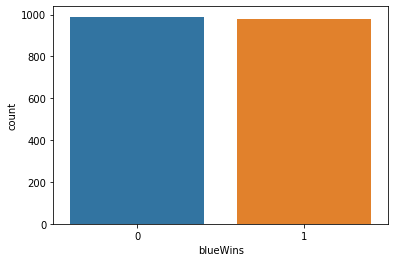

<IPython.core.display.Javascript object>

In [31]:
sns.countplot(y_test)
plt.show()

# Support Vector Classifier (1st Trial)

In [32]:
# creating a pipeline and fitting the training data
pipeline = Pipeline([("preprocessing", preprocessing), ("svc", SVC())])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['blueWardsPlaced',
                                                   'blueWardsDestroyed',
                                                   'blueKills', 'blueDeaths',
                                                   'blueAssists',
                                                   'blueEliteMonsters',
                                                   'blueTotalGold',
                             

<IPython.core.display.Javascript object>

In [33]:
# Scoring the training and testing data, we see there is a big case of the model overfitting
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7441269841269841
Test score: 0.6983240223463687


<IPython.core.display.Javascript object>

In [34]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,697,293
Actually Win,301,678


<IPython.core.display.Javascript object>

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       990
           1       0.70      0.69      0.70       979

    accuracy                           0.70      1969
   macro avg       0.70      0.70      0.70      1969
weighted avg       0.70      0.70      0.70      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [36]:
grid = {
    "svc__kernel": ["linear", "rbf", "poly"],
    "svc__C": [1, 10, 100, 1000],
    "svc__degree": [3, 5, 7, 10],
}

model = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['blueWardsPlaced',
                                                              

<IPython.core.display.Javascript object>

In [37]:
# sorting through the grid search, it appears these are the best parameters for the model.
model.best_params_

{'svc__C': 1, 'svc__degree': 3, 'svc__kernel': 'linear'}

<IPython.core.display.Javascript object>

In [38]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7266031746031746
Test score: 0.7084814626714068


<IPython.core.display.Javascript object>

In [39]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,701,289
Actually Win,285,694


<IPython.core.display.Javascript object>

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       990
           1       0.71      0.71      0.71       979

    accuracy                           0.71      1969
   macro avg       0.71      0.71      0.71      1969
weighted avg       0.71      0.71      0.71      1969



<IPython.core.display.Javascript object>

# K Nearest Neighbors (1st Trial)

In [41]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsClassifier())])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['blueWardsPlaced',
                                                   'blueWardsDestroyed',
                                                   'blueKills', 'blueDeaths',
                                                   'blueAssists',
                                                   'blueEliteMonsters',
                                                   'blueTotalGold',
                             

<IPython.core.display.Javascript object>

In [42]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7720634920634921
Test score: 0.6582021330624682


<IPython.core.display.Javascript object>

In [43]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,648,342
Actually Win,331,648


<IPython.core.display.Javascript object>

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       990
           1       0.65      0.66      0.66       979

    accuracy                           0.66      1969
   macro avg       0.66      0.66      0.66      1969
weighted avg       0.66      0.66      0.66      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [45]:
grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "knn__weights": ["distance", "uniform"],
}

model = GridSearchCV(pipeline, grid, cv=2)
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['blueWardsPlaced',
                                                              

<IPython.core.display.Javascript object>

In [46]:
# sorting through the grid search, it appears these are the best parameters for the model.
model.best_params_

{'knn__n_neighbors': 21, 'knn__weights': 'distance'}

<IPython.core.display.Javascript object>

In [47]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 0.6820721178263077


<IPython.core.display.Javascript object>

In [48]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,676,314
Actually Win,312,667


<IPython.core.display.Javascript object>

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       990
           1       0.68      0.68      0.68       979

    accuracy                           0.68      1969
   macro avg       0.68      0.68      0.68      1969
weighted avg       0.68      0.68      0.68      1969



<IPython.core.display.Javascript object>

# Gradient Boosted Classifier (1st Trial)

In [50]:
pipeline = Pipeline([("preprocessing", preprocessing), ("xgb", XGBClassifier())])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['blueWardsPlaced',
                                                   'blueWardsDestroyed',
                                                   'blueKills', 'blueDeaths',
                                                   'blueAssists',
                                                   'blueEliteMonsters',
                                                   'blueTotalGold',
                             

<IPython.core.display.Javascript object>

In [51]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9027301587301587
Test score: 0.669883189436262


<IPython.core.display.Javascript object>

In [52]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,670,320
Actually Win,330,649


<IPython.core.display.Javascript object>

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       990
           1       0.67      0.66      0.67       979

    accuracy                           0.67      1969
   macro avg       0.67      0.67      0.67      1969
weighted avg       0.67      0.67      0.67      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [54]:
grid = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__max_depth": [5, 7, 10],
    "xgb__n_trees": [100, 150, 200],
    "xgb__learning_rate": [0.2, 0.4, 0.6, 0.8, 1],
}
model = GridSearchCV(pipeline, grid, cv=2)
model.fit(X_train, y_train)

C:\Users\jlim7\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[15:36:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_trees } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['blueWardsPlaced',
                                                              

<IPython.core.display.Javascript object>

In [55]:
# sorting through the grid search, it appears these are the best parameters for the model.
model.best_params_

{'xgb__colsample_bytree': 0.5,
 'xgb__learning_rate': 0.2,
 'xgb__max_depth': 5,
 'xgb__n_trees': 100,
 'xgb__subsample': 1.0}

<IPython.core.display.Javascript object>

In [56]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.8044444444444444
Test score: 0.6876587100050787


<IPython.core.display.Javascript object>

In [57]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,674,316
Actually Win,299,680


<IPython.core.display.Javascript object>

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       990
           1       0.68      0.69      0.69       979

    accuracy                           0.69      1969
   macro avg       0.69      0.69      0.69      1969
weighted avg       0.69      0.69      0.69      1969



<IPython.core.display.Javascript object>

# Comparing Scores 

### Random Forest

* Train score: 1.0
* Test score: 0.6952767902488572

### Random Forest with Grid Search

* Train score: 0.7786666666666666
* Test score: 0.6927374301675978

### Support Vector Classifier

* Train score: 0.7441269841269841
* Test score: 0.6983240223463687

### Support Vector Classifier with Grid Search

* Train score: 0.7266031746031746
* Test score: 0.7084814626714068

### K Nearest Neighbors

* Train score: 0.7720634920634921
* Test score: 0.6582021330624682

### K Nearest Neighbors with Grid Search

* Train score: 1.0
* Test score: 0.6820721178263077

### Gradient Boosted Classifier

* Train score: 0.9027301587301587
* Test score: 0.669883189436262

### Gradient Boosted Classifier with Grid Search

* Train score: 0.8044444444444444
* Test score: 0.6876587100050787

#### Add PCA to the models to see if the scores will be improved

# Random Forest Classifier with PCA (2nd Trial)

In [59]:
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("pca", PCA()), ("rf", RandomForestClassifier()),]
)
pipeline = pipeline.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [60]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 0.6988318943626206


<IPython.core.display.Javascript object>

In [61]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,674,316
Actually Win,299,680


<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [62]:
grid = {
    "pca__n_components": [7, 9, 11, 13, 15, 17],
    "rf__max_depth": [3, 5, 7, 10, 15],
    "rf__min_samples_leaf": [1, 3, 5],
    "rf__criterion": ["gini", "entropy"],
}

model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_we

<IPython.core.display.Javascript object>

In [63]:
model.best_params_

{'pca__n_components': 13,
 'rf__criterion': 'gini',
 'rf__max_depth': 7,
 'rf__min_samples_leaf': 3}

<IPython.core.display.Javascript object>

In [64]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7605079365079365
Test score: 0.706957846622651


<IPython.core.display.Javascript object>

In [65]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 697              293
Actual Churn                    284              695
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       990
           1       0.70      0.71      0.71       979

    accuracy                           0.71      1969
   macro avg       0.71      0.71      0.71      1969
weighted avg       0.71      0.71      0.71      1969



<IPython.core.display.Javascript object>

# Support Vector Classifier with PCA (2nd Trial)

In [66]:
pipeline = Pipeline([("scaler", StandardScaler()), ("pca", PCA()), ("svc", SVC()),])
pipeline = pipeline.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [67]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7445079365079366
Test score: 0.6957846622651092


<IPython.core.display.Javascript object>

In [68]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 696              294
Actual Churn                    305              674
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       990
           1       0.70      0.69      0.69       979

    accuracy                           0.70      1969
   macro avg       0.70      0.70      0.70      1969
weighted avg       0.70      0.70      0.70      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [69]:
grid = {
    "pca__n_components": [3, 5, 7, 9, 11, 13, 15, 17],
    "svc__C": [1, 10, 100, 500],
    "svc__kernel": ["linear", "rbf", "poly"],
    "svc__degree": [1, 2, 3],
}

model = GridSearchCV(pipeline, grid, cv=2)
model.fit(X_train, y_train)

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                           

<IPython.core.display.Javascript object>

In [70]:
model.best_params_

{'pca__n_components': 13,
 'svc__C': 10,
 'svc__degree': 1,
 'svc__kernel': 'poly'}

<IPython.core.display.Javascript object>

In [71]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7266031746031746
Test score: 0.7084814626714068


<IPython.core.display.Javascript object>

In [72]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 701              289
Actual Churn                    285              694
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       990
           1       0.71      0.71      0.71       979

    accuracy                           0.71      1969
   macro avg       0.71      0.71      0.71      1969
weighted avg       0.71      0.71      0.71      1969



<IPython.core.display.Javascript object>

# K Nearest Neighbors With PCA (2nd Trial)

In [73]:
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("pca", PCA()), ("knn", KNeighborsClassifier()),]
)
pipeline = pipeline.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [74]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7780317460317461
Test score: 0.649060436769934


<IPython.core.display.Javascript object>

In [75]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 641              349
Actual Churn                    342              637
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       990
           1       0.65      0.65      0.65       979

    accuracy                           0.65      1969
   macro avg       0.65      0.65      0.65      1969
weighted avg       0.65      0.65      0.65      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model

In [76]:
grid = {
    "pca__n_components": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "knn__weights": ["distance", "uniform"],
}

model = GridSearchCV(pipeline, grid, cv=2)
model.fit(X_train, y_train)

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkows

<IPython.core.display.Javascript object>

In [77]:
model.best_params_

{'knn__n_neighbors': 21, 'knn__weights': 'uniform', 'pca__n_components': 13}

<IPython.core.display.Javascript object>

In [78]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.7310476190476191
Test score: 0.6805485017775521


<IPython.core.display.Javascript object>

In [79]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 673              317
Actual Churn                    312              667
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       990
           1       0.68      0.68      0.68       979

    accuracy                           0.68      1969
   macro avg       0.68      0.68      0.68      1969
weighted avg       0.68      0.68      0.68      1969



<IPython.core.display.Javascript object>

# Gradient Boosted Classifier With PCA (2nd Trial)

In [80]:
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("pca", PCA()), ("xgb", XGBClassifier()),]
)
pipeline = pipeline.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [81]:
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.9008253968253969
Test score: 0.6795327577450483


<IPython.core.display.Javascript object>

In [82]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 684              306
Actual Churn                    325              654
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       990
           1       0.68      0.67      0.67       979

    accuracy                           0.68      1969
   macro avg       0.68      0.68      0.68      1969
weighted avg       0.68      0.68      0.68      1969



<IPython.core.display.Javascript object>

#### Add a grid search to optimize model


In [84]:
grid = {
    "pca__n_components": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb__max_depth": [5, 7, 10],
}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=17 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=19 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

  FitFailedWarning)
C:\Users\jlim7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=21 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
          

<IPython.core.display.Javascript object>

In [85]:
model.best_params_

{'pca__n_components': 13,
 'xgb__colsample_bytree': 0.5,
 'xgb__max_depth': 5,
 'xgb__subsample': 1.0}

<IPython.core.display.Javascript object>

In [86]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.885968253968254
Test score: 0.6886744540375825


<IPython.core.display.Javascript object>

In [87]:
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actual No Churn", "Actual Churn"],
    columns=["Predicted No Churn", "Predicted Churn"],
)
print(con_mat)
print(classification_report(y_test, y_pred))

                 Predicted No Churn  Predicted Churn
Actual No Churn                 691              299
Actual Churn                    314              665
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       990
           1       0.69      0.68      0.68       979

    accuracy                           0.69      1969
   macro avg       0.69      0.69      0.69      1969
weighted avg       0.69      0.69      0.69      1969



<IPython.core.display.Javascript object>